In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup
from cryoS2Sdrop.dataloader import singleCET_dataset, singleCET_FourierDataset, randomRotation3D

import torch
from torch import nn
import torchvision.transforms as T

import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

PARENT_PATH = setup.PARENT_PATH

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

# SingleCET dataset

In [41]:
# cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo02.mrc') 
# cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_dummy.mrc')

simulated_model = 'model14'
cet_path = os.path.join(
    PARENT_PATH, "data/S2SDenoising/dummy_tomograms/tomoPhantom_%s_Poisson5000+Gauss5+stripes.mrc" %simulated_model
)
gt_cet_path = os.path.join(
    PARENT_PATH, "data/S2SDenoising/dummy_tomograms/tomoPhantom_%s.mrc" %simulated_model
)

p=0.3
batch_size = 4
num_gpus = 2
subtomo_length = 128

transform = randomRotation3D(0.5)

my_dataset = singleCET_dataset(cet_path, subtomo_length, p=p, volumetric_scale_factor=8, transform=transform)
print('Size of dataset: %i, Steps per epoch: %i' %(len(my_dataset), len(my_dataset)/(batch_size*num_gpus)))

Size of dataset: 32, Steps per epoch: 4


In [42]:
idx = 0
subtomo, target, mask = my_dataset[idx]
subtomo.shape

torch.Size([1, 128, 128, 128])

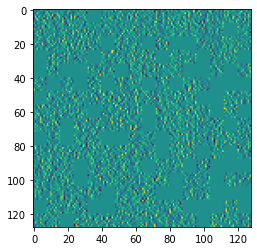

In [45]:
zidx = subtomo_length//2
plt.imshow(subtomo.squeeze()[zidx])

In [25]:
my_dataset.create_Pmask().shape, my_dataset.create_Vmask().shape

(torch.Size([1, 128, 128, 128]), torch.Size([1, 128, 128, 128]))

# SingleCET Fourier Dataset

In [52]:
# cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo02.mrc') 
# cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_dummy.mrc')

simulated_model = 'model14'
cet_path = os.path.join(
    PARENT_PATH, "data/S2SDenoising/dummy_tomograms/tomoPhantom_%s_Poisson5000+Gauss5+stripes.mrc" %simulated_model
)
gt_cet_path = os.path.join(
    PARENT_PATH, "data/S2SDenoising/dummy_tomograms/tomoPhantom_%s.mrc" %simulated_model
)

p=0.3
batch_size = 4
num_gpus = 2
subtomo_length = 128

my_dataset = singleCET_FourierDataset(cet_path, subtomo_length, p=p, volumetric_scale_factor=8, transform=None, gt_tomo_path=gt_cet_path)
print('Size of dataset: %i, Steps per epoch: %i' %(len(my_dataset), len(my_dataset)/(batch_size*num_gpus)))

Creating Fourier samples...
Done!
Size of dataset: 8, Steps per epoch: 1


In [53]:
idx = 4
subtomo, target, gt_subtomo = my_dataset[idx]
subtomo.shape, gt_subtomo.shape

(torch.Size([6, 1, 128, 128, 128]), torch.Size([6, 1, 128, 128, 128]))

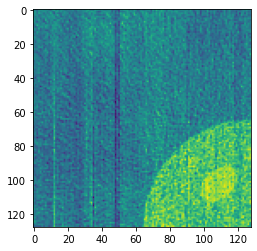

In [54]:
zidx = subtomo_length//2
plt.imshow(subtomo[0][0][zidx])

In [75]:
class randomRotation3D_fourierSamples(object):
    def __init__(self, p):
        assert p >= 0 and p <= 1
        self.p = p
        
    def make3D_rotation(self, subtomo, target, gt_subtomo):
        "3D rotation in ZYX sets of images."
        # 180º rotation around Y axis
        if np.random.uniform() < self.p:
            subtomo = torch.rot90(subtomo, k=2, dims=(0, 2))
            target = torch.rot90(target, k=2, dims=(0, 2))
            gt_subtomo = torch.rot90(gt_subtomo, k=2, dims=(0, 2))
        # 180º rotation around X axis
        if np.random.uniform() < self.p:
            subtomo = torch.rot90(subtomo, k=2, dims=(0, 1))
            target = torch.rot90(target, k=2, dims=(0, 1))
            gt_subtomo = torch.rot90(gt_subtomo, k=2, dims=(0, 1))
        # rotation between 90º and 270º around Z axis
        if np.random.uniform() < self.p:
            k = int(np.random.choice([1, 2, 3]))
            subtomo = torch.rot90(subtomo, k=k, dims=(1, 2))
            target = torch.rot90(target, k=k, dims=(1, 2))
            gt_subtomo = torch.rot90(gt_subtomo, k=k, dims=(1, 2))
        
        return subtomo, target, gt_subtomo

    def __call__(self, subtomo, target, gt_subtomo):
        "Input are of shape [M, C, S, S, S]"
        s, t = subtomo.flatten(start_dim=0, end_dim=1), target.flatten(start_dim=0, end_dim=1)
        if gt_subtomo is not None:
            g = gt_subtomo.flatten(start_dim=0, end_dim=1)
        else:
            g = torch.zeros_like(s)
            
        subtomo_rotated, target_rotated, gt_subtomo_rotated = [], [], []

        for values in zip(s, t, g):
            a, b, c = transform.make3D_rotation(*values)
            subtomo_rotated.append(a)
            target_rotated.append(b)
            gt_subtomo_rotated.append(c)

        subtomo_rotated = torch.stack(subtomo_rotated).reshape(subtomo.shape)
        target_rotated = torch.stack(target_rotated).reshape(target.shape)
        gt_subtomo_rotated = torch.stack(gt_subtomo_rotated).reshape(gt_subtomo.shape)
        
        if (gt_subtomo_rotated==0).all():
            gt_subtomo_rotated = None
        
        return subtomo_rotated, target_rotated, gt_subtomo_rotated

    def __repr__(self):
        return repr("randomRotation3D with probability %.02f" % self.p)

In [76]:
transform = randomRotation3D_fourierSamples(0.5)
s, t, g = transform(subtomo, target, gt_subtomo)

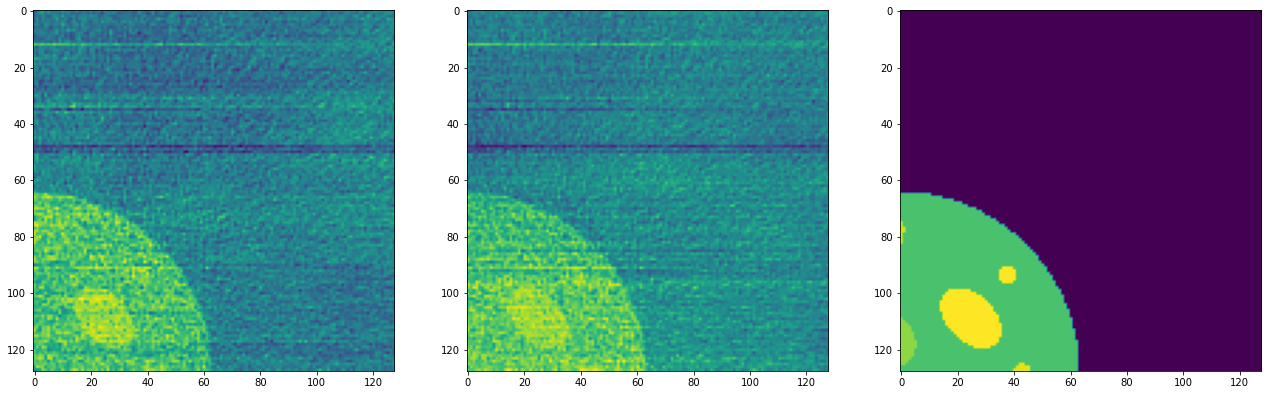

In [79]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(22, 10))
zidx = subtomo_length//2
ax0.imshow(s[0][0][zidx])
ax1.imshow(t[0][0][zidx])
ax2.imshow(g[0][0][zidx])